In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import keras
from keras.layers import Dense, Conv1D, Flatten, Dropout, BatchNormalization, Activation
from keras.models import Sequential
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import librosa
from sklearn.preprocessing import OneHotEncoder, StandardScaler

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

## Savee Dataset

In [2]:
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"
savee_directiory_list = os.listdir(Savee)

emotion_df = []

for wav in savee_directiory_list:
    info = wav.partition(".wav")[0].split("_")[1].replace(r"[0-9]", "")
    emotion = re.split(r"[0-9]", info)[0]
    if emotion=='a':
        emotion_df.append(("angry", Savee + "/" + wav))
    elif emotion=='d':
        emotion_df.append(("disgust", Savee + "/" + wav))
    elif emotion=='f':
        emotion_df.append(("fear", Savee + "/" + wav))
    elif emotion=='h':
        emotion_df.append(("happy", Savee + "/" + wav))
    elif emotion=='n':
        emotion_df.append(("neutral", Savee + "/" + wav))
    elif emotion=='sa':
        emotion_df.append(("sad", Savee + "/" + wav))
    else:
        emotion_df.append(("surprise", Savee + "/" + wav))


Savee_df = pd.DataFrame.from_dict(emotion_df)
Savee_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

Savee_df.head()
df1 = Savee_df 

## TESS Dataset

In [3]:
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
tess = os.listdir("/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/")
emotions = []
files = []

for item in tess:
    items = os.listdir(Tess + item)
    for file in items:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part == 'ps':
            emotions.append('surprise')
        else:
            emotions.append(part)
        files.append(Tess + item + '/' + file)
        
tess_df = pd.concat([pd.DataFrame(emotions, columns=['Emotion']), pd.DataFrame(files, columns=['Path'])], axis=1)

tess_df
df2 = tess_df 

In [4]:
df = pd.concat([df1, df2])

In [5]:
df = df.sample(frac=1)

In [6]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

## Data Augmentation

In [7]:
# Augmentation
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size = data.shape[0])
    return data

def stretch(data, rate = 0.8):
    return librosa.effects.time_stretch(data, rate = rate)

def shift(data):
    shift_range = int(np.random.uniform(low = -5, high = 5) * 1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor = 0.7):
    return librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps = pitch_factor)

In [8]:
train_df

,Emotion,Path
1263,sad,/kaggle/input/toronto-emotional-speech-set-tes...
131,fear,/kaggle/input/toronto-emotional-speech-set-tes...
222,angry,/kaggle/input/toronto-emotional-speech-set-tes...
2600,surprise,/kaggle/input/toronto-emotional-speech-set-tes...
534,fear,/kaggle/input/toronto-emotional-speech-set-tes...
...,...,...
969,neutral,/kaggle/input/toronto-emotional-speech-set-tes...
859,neutral,/kaggle/input/toronto-emotional-speech-set-tes...
714,disgust,/kaggle/input/toronto-emotional-speech-set-tes...
618,disgust,/kaggle/input/toronto-emotional-speech-set-tes...


## Feature Extraction

In [9]:
X, Y = [], []
for path, emotion, ind, in zip(train_df.Path, train_df.Emotion, range(train_df.Path.shape[0])):
    x, sample_rate = librosa.load(path)
    mfcc = np.mean(librosa.feature.mfcc(y=x, sr=sample_rate, n_mfcc=40).T, axis=0)
    X.append(mfcc)
    Y.append(emotion)
    x2 = noise(x)
    mfcc = np.mean(librosa.feature.mfcc(y=x2, sr=sample_rate, n_mfcc=40).T, axis=0)
    X.append(mfcc)
    Y.append(emotion)
    x3 = stretch(x)
    x3 = pitch(x3, sample_rate)
    mfcc = np.mean(librosa.feature.mfcc(y=x3, sr=sample_rate, n_mfcc=40).T, axis=0)
    X.append(mfcc)
    Y.append(emotion)
    if ind%100==0:
        print('%2d Samples processed' % (ind))

 0 Samples processed
100 Samples processed
200 Samples processed
300 Samples processed
400 Samples processed
500 Samples processed
600 Samples processed
700 Samples processed
800 Samples processed
900 Samples processed
1000 Samples processed
1100 Samples processed
1200 Samples processed
1300 Samples processed
1400 Samples processed
1500 Samples processed
1600 Samples processed
1700 Samples processed
1800 Samples processed
1900 Samples processed
2000 Samples processed
2100 Samples processed
2200 Samples processed


In [10]:
X_train, y_train = np.asarray(X), np.asarray(Y)

In [11]:
X, Y = [], []
for path, emotion, ind, in zip(test_df.Path, test_df.Emotion, range(test_df.Path.shape[0])):
    x, sample_rate = librosa.load(path)
    mfcc = np.mean(librosa.feature.mfcc(y=x, sr=sample_rate, n_mfcc=40).T, axis=0)
    X.append(mfcc)
    Y.append(emotion)

In [12]:
X_test, y_test = np.asarray(X), np.asarray(Y)

In [13]:
onehot_encoder = OneHotEncoder(sparse=False)
y_train = onehot_encoder.fit_transform(y_train.reshape(-1, 1))
X_train = np.expand_dims(X_train, axis=2)
y_test = onehot_encoder.fit_transform(y_test.reshape(-1, 1))
X_test = np.expand_dims(X_test, axis=2)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [14]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6888, 40, 1), (6888, 7), (984, 40, 1), (984, 7))

In [15]:
def noise(data, random=False, rate=0.035, threshold=0.075):
    if random:
        rate = np.random.random() * threshold
    noise_amp = rate*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data, rate=1000):
    shift_range = int(np.random.uniform(low=-5, high = 5)*rate)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7, random=False):
    if random:
        pitch_factor=np.random.random() * pitch_factor
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

In [16]:
input_shape=(40, 1)

## Model

In [17]:
model = Sequential()
model.add(Conv1D(64, 5, padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(7))
model.add(Activation('softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 64)            384       
                                                                 
 activation (Activation)     (None, 40, 64)            0         
                                                                 
 dropout (Dropout)           (None, 40, 64)            0         
                                                                 
 flatten (Flatten)           (None, 2560)              0         
                                                                 
 dense (Dense)               (None, 7)                 17927     
                                                                 
 activation_1 (Activation)   (None, 7)                 0         
                                                                 
Total params: 18,311
Trainable params: 18,311
Non-traina

In [18]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
earlystopping = keras.callbacks.EarlyStopping(monitor ="val_acc", patience = 5, verbose=1, restore_best_weights = True)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [20]:
type(y_train)

numpy.ndarray

## Training

In [21]:
history = model.fit(X_train, y_train, batch_size=64, epochs=100, verbose='auto', validation_data=(X_test, y_test), callbacks=[earlystopping, learning_rate_reduction])

Epoch 1/100
108/108 [==============================] - 2s 9ms/step - loss: 2.1381 - accuracy: 0.6169 - val_loss: 0.6294 - val_accuracy: 0.8608 - lr: 0.0010
Epoch 2/100
108/108 [==============================] - 1s 7ms/step - loss: 0.6898 - accuracy: 0.8275 - val_loss: 0.4493 - val_accuracy: 0.8679 - lr: 0.0010
Epoch 3/100
108/108 [==============================] - 1s 7ms/step - loss: 0.4452 - accuracy: 0.8735 - val_loss: 0.5285 - val_accuracy: 0.8404 - lr: 0.0010
Epoch 4/100
108/108 [==============================] - 1s 7ms/step - loss: 0.3499 - accuracy: 0.8918 - val_loss: 0.5010 - val_accuracy: 0.8445 - lr: 0.0010
Epoch 5/100
108/108 [==============================] - 1s 7ms/step - loss: 0.2918 - accuracy: 0.9048 - val_loss: 0.2403 - val_accuracy: 0.9126 - lr: 0.0010
Epoch 6/100
108/108 [==============================] - 1s 7ms/step - loss: 0.2613 - accuracy: 0.9155 - val_loss: 0.2567 - val_accuracy: 0.9106 - lr: 0.0010
Epoch 7/100
108/108 [==============================] - 1s 7ms/st

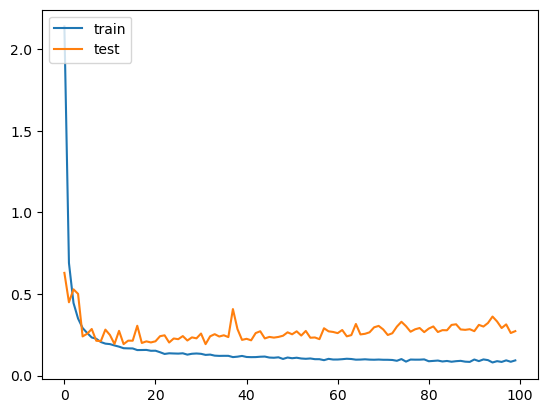

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'test'], loc='upper left')

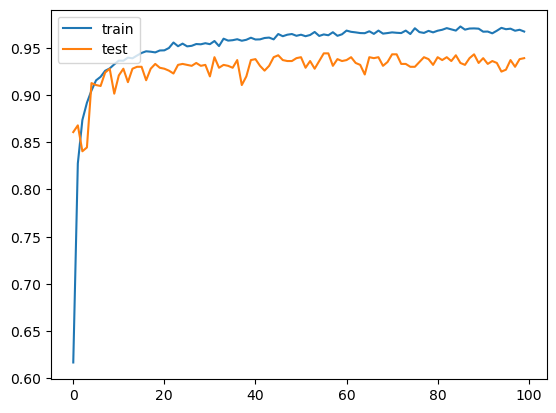

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'test'], loc='upper left')

## Confusion Matrix

In [40]:
y_pred = model.predict(X_test)

31/31 [==============================] - 0s 3ms/step


In [42]:
y_pred = onehot_encoder.inverse_transform(y_pred)

In [44]:
y_check = onehot_encoder.inverse_transform(y_test)

Confusion matrix, without normalization
[[127   1   3   9   1   0   0]
 [  0 122   2   0   0   2   3]
 [  0   1 143   0   0   1   1]
 [  6   0   7 128   0   0   0]
 [  0   0   0   0 146   4   0]
 [  0   0   0   0   8 136   0]
 [  0   1   5   5   0   0 122]]


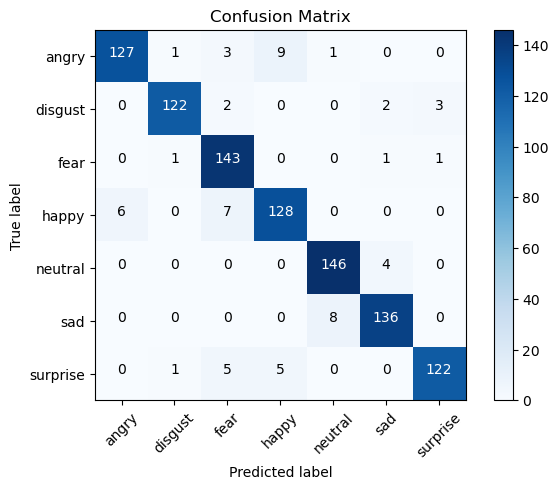

In [47]:
from sklearn.metrics import confusion_matrix
import itertools
cm = confusion_matrix(y_true=y_check, y_pred=y_pred)
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
cm_plot_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

## Results

In [48]:
model.evaluate(X_test, y_test)

31/31 [==============================] - 0s 2ms/step - loss: 0.2727 - accuracy: 0.9390


[0.27269190549850464, 0.9390243887901306]

In [49]:
model.save('NewModel.h5')